# Interactive Learning Course
## HW #2, Multi-Armed Bandits

In [1]:
import numpy as np
from abc import ABC, abstractmethod
#import gym
import matplotlib.pyplot as plt
import math

# Part 2

## Reward class

In [2]:
class Reward(ABC):
    def __init__(self, debts=[5, 20, 100]):
        super(Reward, self).__init__()
        self.debts = debts
        
    @abstractmethod
    def get_reward(self, action):
        pass

In [3]:
class Student(Reward):
    def __init__(self):
        super(Student, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([4, 5, 5.1], p=[0.2, 0.2, 0.6]) #expected value :4.86 - 5 = - 0.86
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.5, 0.3, 0.1, 0.1]) #expected value :9.575 - 20 = -10.425
        else:
            obs = np.random.choice([10, 20, 50, 100, 105], p=[0.5, 0.3, 0.1, 0.05, 0.05]) #expected value :26.25 - 100 = -73.75
        
        return obs, obs - self.debts[action]

In [4]:
class GovStaff(Reward):
    def __init__(self):
        super(GovStaff, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([4, 5, 5.1], p=[0.05, 0.3, 0.65])#expected value :5.015 - 5 = 0.015
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.1, 0.1, 0.3, 0.5])#expected value :17.875 - 20 = -2.125
        else:
            obs = np.random.choice([20, 50, 80, 100, 105], p=[0.1, 0.1, 0.2, 0.3, 0.3])#expected value :84.5 - 100 = -15.5
        
        return obs, obs - self.debts[action]

In [5]:
class SelfEmp(Reward):
    def __init__(self):
        super(SelfEmp, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([0, 2.5, 5.1], p=[0.8, 0.1, 0.1])#expected value :0.76 - 5 = -4.24
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.05, 0.05, 0.3, 0.6])#expected value :19.2 - 20 =- 0.8
        else:
            obs = np.random.choice([20, 50, 80, 100, 105], p=[0.02, 0.03, 0.05, 0.2, 0.7])#expected value :99.4 - 100 =-0.6
        
        return obs, obs - self.debts[action]

## Environment

In [6]:
class Environment:
    def __init__(self, id, reward):
        self.reward = reward
    
    def calc_reward(self, action):
        ob, ob_debts = self.reward.get_reward(action)
        return ob, ob_debts
        

    def get_available_actions(self):
        return 3
        

# Part 3

In [7]:
class Agent_epsilonGreedy:
    def __init__(self, _id, env=None, alpha=0, beta=1, gamma=1,epsilon = 0.2):
        #self.id = _id
        self.env = env
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.epsilon = epsilon
        self.q = [0]*3 # mean rewards for each arm
        self.mean = 0 # mean rewards for selected actions
        self.trial = 0
        
        

    def choose_action(self):
        p = np.random.uniform()
        
        if p < self.epsilon:
            action = np.random.choice(3)
        else:
            action = np.random.choice([i for i, val in enumerate(self.q) if val == max(self.q)])
        return action
    
    def calculate_utility(self, reward):
        util = self.beta * (reward**self.gamma) + self.alpha
        return util
    
    def take_action(self, action):
        ob, ob_debts = self.env.calc_reward(action)
        return ob, ob_debts
    
    def update_value(self, action, util):
        self.trial += 1
        self.q[action] =  (self.q[action]*(self.trial - 1) + util) / self.trial
        self.mean =  (self.mean*(self.trial - 1) + util) / self.trial

    def step(self, best_reward, trial):
        action = self.choose_action()
        _, reward = self.take_action(action)
        utility = self.calculate_utility(reward)
        self.update_value(action, utility)
        return utility

    def reset(self):
        return
    
    def get_rewards(self):
        return
    
    def get_regrets(self):
        return

In [8]:
class Agent_gradient:
    def __init__(self, _id, env=None, lr = None , alpha=0, beta=1, gamma=1):
        self.env = env
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.mean = 0 # mean rewards for selected actions
        self.trial = 0
        self.h = [0]*3 #preference for each arm
        self.p = [0]*3 # probability for each arm

    def choose_action(self):
        exp_of_h = [np.exp(i) for i in self.h]
        sum_of_preferences = np.sum(exp_of_h)
        self.p = [exp_of_h[i] / sum_of_preferences for i in range(len(exp_of_h))]
        action = np.random.choice([i for i, val in enumerate(self.p) if val == max(self.p)])
        return action
    
    def calculate_utility(self, reward):
        util = self.beta * (reward**self.gamma) + self.alpha
        return util
    
    def take_action(self, action):
        ob, ob_debts = self.env.calc_reward(action)
        return ob, ob_debts
    
    def update_value(self, action, util):
        self.trial += 1
        
        self.h[action] += self.lr*(util-self.mean)*(1-(self.p[action]))
        for i in range(3):
            if i != action:
                self.h[i] -= self.lr*(util-self.mean)*(self.p[i])
        
        self.mean =  (self.mean*(self.trial - 1) + util) / self.trial

    def step(self, best_reward, trial):
        action = self.choose_action()
        _, reward = self.take_action(action)
        utility = self.calculate_utility(reward)
        self.update_value(action, utility)
        return utility

    def reset(self):
        return
    
    def get_rewards(self):
        return
    
    def get_regrets(self):
        return

In [9]:
class Agent_UCB:
    def __init__(self, _id, env=None, alpha=0, beta=1, gamma=1,c= 2):
        self.env = env
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.c = c
        self.mean = 0 # mean rewards for selected actions
        self.q =[0]*3 # mean rewards for each arm
        self.ucb = [0]*3 # probability for each arm
        self.trial = 0
        self.counts = [0]*3 # number of run for each action

        

    def choose_action(self):
        for i in range(len(self.ucb)):
            if self.counts[i] == 0:
                self.ucb [i] = math.inf
            else:
                
                self.ucb [i]= self.q[i] + self.c * np.sqrt((2 * np.log(self.trial) )/ (1 + self.counts[i]))

        action = np.random.choice([i for i, val in enumerate(self.ucb) if val == max(self.ucb)])
        return action
    
    def calculate_utility(self, reward):
        util = self.beta * (reward**self.gamma) + self.alpha
        return util
    
    def take_action(self, action):
        obs, reward = self.env.calc_reward(action)
        return obs, reward
    
    def update_value(self, action, util):
        self.trial += 1
        self.counts [action] += 1
        self.q[action] =  (self.q[action]*(self.trial - 1) + util) / self.trial
        self.mean =  (self.mean*(self.trial - 1) + util) / self.trial

    def step(self, best_reward, trial):
        action = self.choose_action()
        _, reward = self.take_action(action)
        utility = self.calculate_utility(reward)
        self.update_value(action, utility)
        return utility

    def reset(self):
        return
    
    def get_rewards(self):
        return
    
    def get_regrets(self):
        return

# Part 4

In [10]:

def ruun(q_a_star,clientt,Agent,trial,LR):
    mean_rewards = []
    regrets = []
    for i in range(20):
        
        client = clientt()
        env = Environment('1',client)
        if Agent  == Agent_gradient :
            agent = Agent('1',env,LR)
        else:
            agent = Agent('1',env)

        rewards = []
        mean_r = []
        regret = []
        for step in range(trial):
            
            reward = agent.step(_,_)
            rewards.append(reward)
            mean_r.append(agent.mean)
            regret.append((step+1)*q_a_star - np.sum(rewards))
        
        mean_rewards.append(mean_r)
        regrets.append(regret)
        
    return np.mean(mean_rewards, axis = 0),np.mean(regrets, axis = 0)



In [11]:
def plott(a,b,c,title,y_label): 

    #plt.figure(figsize=(25,8))
    plt.plot(range(0,100), a, color='r', label='epsilonGreedy')
    plt.plot(range(0,100), b, color='b', label='gradient')
    plt.plot(range(0,100), c, color='g', label='UCB')
    plt.xlabel("Trials")
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

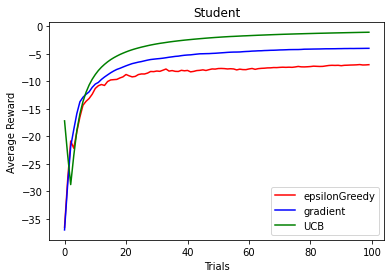

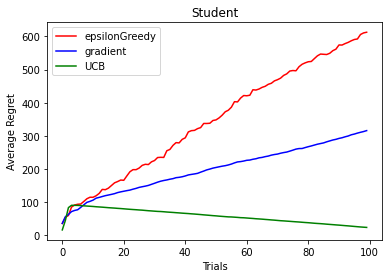

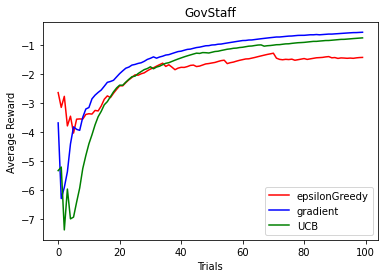

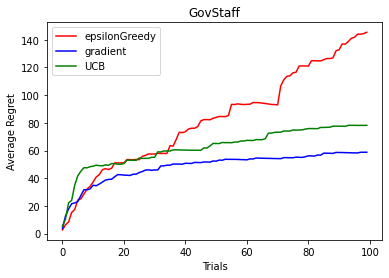

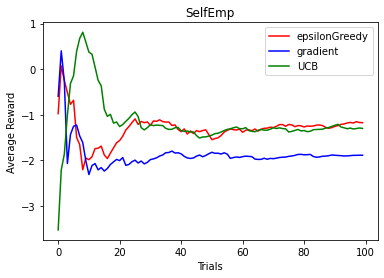

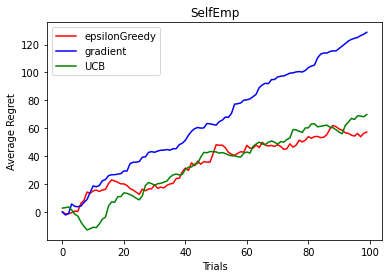

In [12]:
titels = ['Student','GovStaff','SelfEmp']
y_lable = ['Average Reward','Average Regret']
k = 0
trial = 100
LR = 0.001

for i in [(Student,-0.86),(GovStaff, 0.015),(SelfEmp, -0.6)]:
    
    w= []
    g = []

    for j in [Agent_epsilonGreedy, Agent_gradient, Agent_UCB]:
        q_a_star = i[1]
        rew,reg  = ruun(q_a_star,i[0],j,trial,LR)
        w.append(rew)
        g.append(reg)
    plott(w[0],w[1],w[2],titels[k],y_lable[0])
    plott(g[0],g[1],g[2],titels[k],y_lable[1])
    k = k+1

        

# Part 5

In [13]:
def plottt(a,b,c,d,trial,title,y_label,LR): 

    #plt.figure(figsize=(25,8))
    plt.plot(range(0,trial), a, color='r', label=LR[0] )
    plt.plot(range(0,trial), b, color='b', label=LR[1])
    plt.plot(range(0,trial), c, color='g', label=LR[2])
    plt.plot(range(0,trial), d, color='y', label=LR[3])
    plt.xlabel("Trials")
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

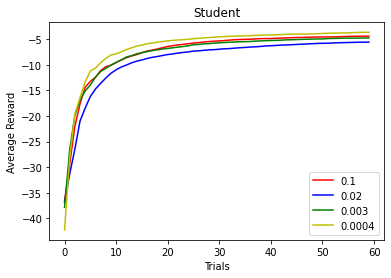

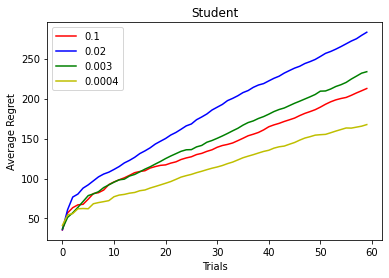

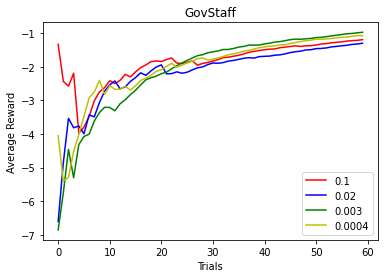

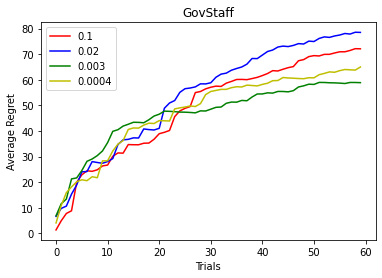

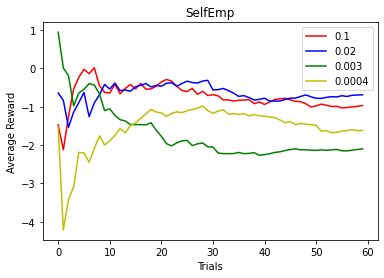

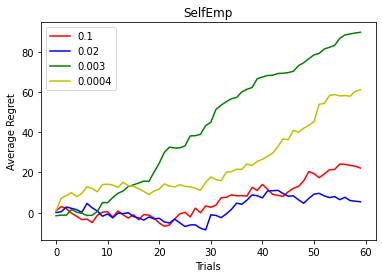

In [14]:
titels = ['Student','GovStaff','SelfEmp']
y_lable = ['Average Reward','Average Regret']
k = 0
trial = 60
LR = [0.1,0.02,0.003,0.0004]

for i in [(Student,-0.86),(GovStaff, 0.015),(SelfEmp, -0.6)]:
    
    w= []
    g = []

    for j in LR:
        q_a_star = i[1]
        rew,reg  = ruun(q_a_star,i[0],Agent_gradient,trial,j)
        w.append(rew)
        g.append(reg)
    
    plottt(w[0],w[1],w[2],w[3],trial,titels[k],y_lable[0],LR)
    plottt(g[0],g[1],g[2],g[3],trial,titels[k],y_lable[1],LR)
    k = k+1

        